In [10]:
# we implement a discret-time version of the birth-death process described in the paper

from pylab import *;
import pandas as pd;
from scipy.interpolate import interp1d

#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True


%matplotlib inline

def simu(f,x0,N,timeHorizon):
    P = [0 for i in range(0,N+1)]
    P[int(N*x0)] = 1;
    m = [x0];
    v = [x0**2];
    T = [0];
    myF = [f(i/N) for i in range(0,N+1)];
    
    for t in range(0,timeHorizon*N):
        newP = [0 for i in range(0,N+1)];
        for i in range(1,N):
            newP[i] = 1/2*P[i] + (1/4+myF[i-1]/2) * P[i-1] + (1/4-myF[i+1]/2) * P[i+1];
        newP[0] = (3/4-myF[0]/2) * P[0] + (1/4-myF[1]/2)*P[1];
        newP[N] = (3/4+myF[N]/2) * P[N] + (1/4+myF[N-1]/2)*P[N-1];
        P = newP;
        m.append(sum([i*P[i] for i in range(1,N+1)])/N);
        v.append(sum([(i**2)*P[i] for i in range(1,N+1)])/N/N);
        T.append((t+1)/N);
    #print(P)
    return((T,m,v))

def ode(f,x0,timeHorizon):
    h = 0.0001;
    m = [x0];
    x = x0;
    T = [0]
    for t in range(0,int(timeHorizon/h)):
        x = x+h*f(x);
        m.append(x)
        T.append((t+1)*h)
    return((T,m));

def steady_state(f,N):
    P = zeros(N+1);
    P[int(N/2)] = 1;
    for i in range(int(N/2),N):
        P[i+1] = (1+1/2*f((i)/N)) / (1-1/2*f((i+1)/N)) * P[i];
    for i in range(int(N/2),0,-1):
        P[i-1] = (1-1/2*f((i)/N)) / (1+1/2*f((i-1)/N)) * P[i];
    P[-1] = P[-2] * (1+1/2*f((N-1)/N)) / (-f(1))
    P[0] = (1-1/2*f(1/N))/f(0) * P[1]
    return(P/sum(P))
def steady_state_OLD(f,N):
    p = f(0)/(1-1/2*f(1/N));
    P = [1,p];
    for i in range(1,N):
        p *= (1+1/2*f((i)/N)) / (1-1/2*f((i+1)/N))
        P.append(p);
    P[-1] = P[-2] * (1+1/2*f((N-1)/N)) / (-f(1))
    P = array(P);
    return(P/sum(P))
#S1 = steady_state(lambda x:f_Calpha(x,.5),20)
#S2 = steady_state_OLD(lambda x:f_Calpha(x,.5),20)
#print(S1-S2)

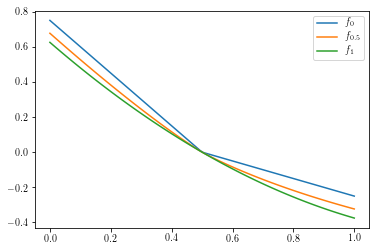

In [11]:
def f_Lipschitz(x):
    y = -.5*(x-.5) if x>.5 else .5-x
    return(y)
def f_C1(x):
    y = -(x-.5) + ((x-.5)**1.5 if x>.5 else 0)
    return(y)
def f_C2(x):
    y = -(x-.5) + ((x-.5)**2 if x>.5 else 0)
    return(y ) 
def f_Calpha(x,alpha):
    y = -(x-.5) + .5*(abs(x-.5))**(1+alpha) # ((x-.5)**(1+alpha) if x>.5 else -.5*(x-.5)**2)
    return(y)

if True:
    f1 = figure(0); 
    xx = linspace(0,1,100)
    for alpha in [0,.5,1]:
        plot(xx,[f_Calpha(x,alpha) for x in xx])
        #plot(xx,[f_Lipschitz(x) for x in xx]); xlabel('x'); ylabel('f(x)')
        #plot(xx,[f_C1(x) for x in xx])
        #plot(xx,[f_C2(x) for x in xx])
    legend(('$f_0$','$f_{0.5}$','$f_1$'))
    f1.savefig('functions_f.pdf',bbox_inches='tight')

if False:
    for (k,alpha) in enumerate([0,.5,1]):
        f = lambda x: f_Calpha(x,alpha);
        #for (k,f) in enumerate([f_Lipschitz, f_C1, f_C2]):
        fig = figure(k+1)
        fig.set_size_inches(4,3);
        x0 = 0.4
        for N in [10,50,100,500]:
            (t1,m1,v1) = simu(f,x0,N=N, timeHorizon=10)
            plot(t1,m1)
        (t2,m2) = ode(f,x0, timeHorizon=10)
        plot(t2,m2,'--')
        xlim([0,8])
        ylim([.4,.56])
        xlabel('time t'); ylabel('E[X^N(t)]')
        legend((' $N=10$', '$N=50$', '$N=100$', '$N=500$', '$N=+\infty$ (limit)'),loc='best')
        fig.savefig('mean_vs_time_C{}.pdf'.format(k),bbox_inches='tight')


In [12]:
x0=0.5;
TMAX=2;
fileNameCVS = 'birthDeath_Nold_x0{0}_Tmax{1}.csv'.format(int(10*x0),TMAX)
try:
    q = pd.DataFrame.from_csv(fileNameCVS)
except:
    print("Unexpected error:", sys.exc_info()[0])
    q = pd.DataFrame({'N':[], 'f':[], 'T':[], 'XN':[], 'x':[]})
#for (k,f) in enumerate([f_Lipschitz, f_C1, f_C2]):
alphaS = [0,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
#[alphaS.append(a) for a in linspace(0,1,6)[1:-1]]
#alphaS.append(1);
#alphaS.append(1.1);
#alphaS.append(1.5);
for k in alphaS:
    #linspace(0,1,10): #enumerate([f_Lipschitz, f_C1, f_C2]):
    f = lambda x: f_Calpha(x,k)
    (t2,m2) = ode(f,x0, timeHorizon=TMAX+.1)
    for N  in [10,20,50,100,200,300,500,1000]: #,500,1000]:
        if not ((q['N']==N) & (q['f']==k)).any():
            (t,M,V) = simu(f,x0,N, timeHorizon=TMAX)
            for T in [1,TMAX]:
                x = interp1d(t2,m2)(T)
                X = interp1d(t,M)(T)
                v = interp1d(t,V)(T)
                q = q.append( {'N':N, 'f':k, 'T':T, 'XN':X,  'VN':v-2*X*x+x**2, 'x':x} , ignore_index=True)
        #else:
            #for T in [1,2,3,4,5]:
            #    x = interp1d(t2,m2)(T)
            #    oldX = q.x[(q['N']==N) & (q['T']==T) & (q['f']==k)]
            #    q.x[(q['N']==N) & (q['T']==T) & (q['f']==k)] = double(x)
                # print(oldX-x)
        print('\r',N,k,end='')
    print('')
    
q.to_csv(fileNameCVS)

 1000 0
 1000 0.01
 1000 0.02
 1000 0.05
 1000 0.1
 1000 0.2
 1000 0.3
 1000 0.4
 1000 0.5
 1000 0.6
 1000 0.7
 1000 0.8
 1000 0.9
 1000 1


In [13]:
# Steady-state
def error_SS(myN,alpha):
    values = zeros(len(myN))
    for (i,N) in enumerate(myN):
        P = steady_state(lambda x: f_Calpha(x,alpha),N)
        values[i] = sum(arange(N+1) * P)/N - 0.5;
    return(values)
def exponent_SS(alpha):
    Nmax=10**5;
    Nmin=10**4;
    valueMax = sum(arange(Nmax+1) * steady_state(lambda x: f_Calpha(x,alpha),Nmax))/Nmax-0.5
    valueMin = sum(arange(Nmin+1) * steady_state(lambda x: f_Calpha(x,alpha),Nmin))/Nmin-0.5
    #print(valueMin,valueMax)
    return(log(valueMin/valueMax)/log(10))
def exponent_SS_L2(alpha):
    Nmax=10**5;
    Nmin=10**4;
    Pmax = steady_state(lambda x: f_Calpha(x,alpha),Nmax);
    Pmin = steady_state(lambda x: f_Calpha(x,alpha),Nmin);
    valueMax = sqrt(sum((arange(Nmax+1)/Nmax-0.5)**2 * Pmax ));
    valueMin = sqrt(sum((arange(Nmin+1)/Nmin-0.5)**2 * Pmin ));
    #print(valueMin,valueMax)
    return(log(valueMin/valueMax)/log(10))

In [6]:
#q[(q['T']==50)]#q.to_csv(fileNameCVS)

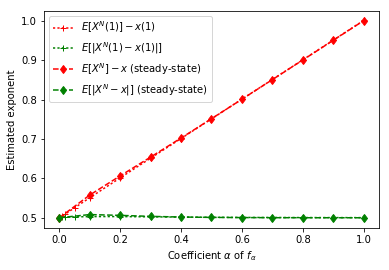

In [7]:
Texp=1
def evaluate_exponent(f,Nmin=100):
    x = q[(q['f']==f) & (q['T']==Texp)]
    Nmax=max(x['N'])
    #Nmin=100
    yMAX = double(x[x['N']==Nmax]['XN'] - x[x['N']==Nmax]['x'])
    yMIN = double(x[x['N']==Nmin]['XN'] - x[x['N']==Nmin]['x'])
    alpha = log(yMAX/yMIN) / log(Nmin/Nmax)
    #print(yMAX)
    C = yMIN * Nmin**alpha;
    return( [C,alpha] )
def evaluate_exponent_var(f,Nmin=100):
    x = q[(q['f']==f) & (q['T']==Texp)]
    Nmax=max(x['N'])
    #Nmin=100
    yMAX = double(x[x['N']==Nmax]['VN'] )
    yMIN = double(x[x['N']==Nmin]['VN'] )
    alpha = log(yMAX/yMIN) / log(Nmin/Nmax)
    #print(yMAX)
    C = yMIN * Nmin**alpha;
    return( [C,alpha] )

fig = figure();
fig.set_size_inches(6,4)
for Nmin in [300]:
    e = [evaluate_exponent(f,Nmin)[1] for f in alphaS]
    eV = array([evaluate_exponent_var(f,Nmin)[1] for f in alphaS])
    plot(alphaS,e,'r+:')
    plot(alphaS,eV/2,'g+:')
myAlpha = linspace(0,1,11);
plot(myAlpha,[exponent_SS(alpha) for alpha in myAlpha],'rd--')
plot(myAlpha,[exponent_SS_L2(alpha) for alpha in myAlpha],'gd--')
legend(('$E[X^N(1)]-x(1)$',
        '$E[\|X^N(1)-x(1)\|]$',
        '$E[X^N]-x$ (steady-state)',
        '$E[\|X^N-x\|]$ (steady-state)'),loc='best')

xlabel('Coefficient $\\alpha$ of $f_{\\alpha}$')
ylabel('Estimated exponent')
fig.savefig('exponent_birthDeath.pdf',bbox_inches='tight')

0 [0.098787151266953921, 0.49822265119163928]
0.5 [0.067753178765414909, 0.75138599495749359]
1 [0.050339835746732314, 1.0010935390847946]
0.000500869649317
        N    T        XN    f    x       VN
214  99.5  0.5  0.000501  0.5  0.0 -0.49783
0 [0.24287819108125144, 1.0008253875497009]
0.5 [0.22238374502314448, 1.0036798870066506]
1 [0.21851050101131753, 1.0015057835998329]
0.00217000505534
        N    T        XN    f    x       VN
214  99.5  0.5  0.000501  0.5  0.0 -0.49783


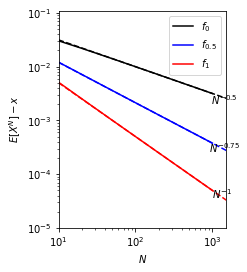

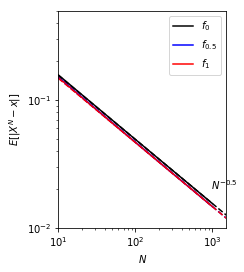

In [8]:
# Convergence of the E[X^N]-x
fig = figure()
fig.set_size_inches(3,4)
colors=['k','b','r']
myAlphas = [0,0.5,1]
for (k,f) in enumerate(myAlphas):
    x = q[(q['f']==f) & (q['T']==Texp)]
    loglog(x['N'], (x['XN']-x['x']),color=colors[k])
for (k,f) in enumerate(myAlphas):
    CE = evaluate_exponent(f)
    print(f,CE)
    loglog([10,10000], array([10,10000])**(-CE[1])* CE[0] ,'--',color=colors[k])
print(100**(-CE[1])*CE[0])
print(x[x['N']==100]-.5)
xlim([10,1500])
ylim([10**(-5),.11])
text(950,.002,'$N^{-0.5}$')
text(900,.00025,'$N^{-0.75}$')
text(1000,.000035,'$N^{-1}$')
#for f in [0,1,2]:
ylabel('$E[X^N]-x$')
xlabel('$N$')
legend(('$f_0$','$f_{0.5}$','$f_1$'),loc='best'); #, '$0.2/\sqrt{N}$','$0.3/N^{0.9}$','$0.2/N$'),loc='best')
fig.savefig('rate_birthRate.pdf',bbox_inches='tight')

# Convergence of the E[|X^N-x|]
# note: in the code, the "sqrt" is to use the ROOT mean-square error (instead of mean-square)
fig = figure()
fig.set_size_inches(3,4)
colors=['k','b','r']
myAlphas = [0,0.5,1]
for (k,f) in enumerate(myAlphas):
    x = q[(q['f']==f) & (q['T']==Texp)]
    loglog(x['N'], sqrt(x['VN']),color=colors[k])
for (k,f) in enumerate(myAlphas):
    CE = evaluate_exponent_var(f)
    print(f,CE)
    loglog([10,10000], array([10,10000])**(-CE[1]/2)* sqrt(CE[0]) ,'--',color=colors[k])
print(100**(-CE[1])*CE[0])
print(x[x['N']==100]-.5)
xlim([10,1500])
ylim([10**(-2),.5])
text(950,.02,'$N^{-0.5}$')
ylabel('$E[\|X^N-x\|]$')
xlabel('$N$')
#for f in [0,1,2]:
legend(('$f_0$','$f_{0.5}$','$f_1$'),loc='best'); #, '$0.2/\sqrt{N}$','$0.3/N^{0.9}$','$0.2/N$'),loc='best')
fig.savefig('rate_birthRate_norm2.pdf',bbox_inches='tight')


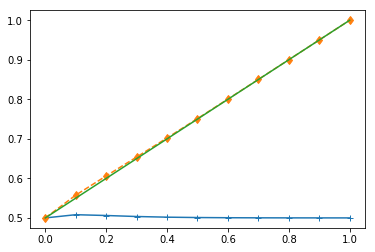

In [9]:


myN = [10,20,50,100,200,300,500,1000,5000,10000];
#for alpha in linspace(0,1,6):
#    loglog(myN,error_SS(myN,alpha))
figure();
myAlpha = linspace(0,1,11);
plot(myAlpha,[exponent_SS_L2(alpha) for alpha in myAlpha],'+-')
plot(myAlpha,[exponent_SS(alpha) for alpha in myAlpha],'d--')
plot(myAlpha,1/2+myAlpha/2)

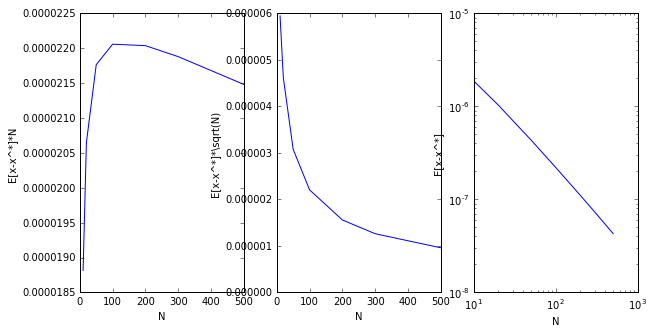

In [258]:
def f(x):
    B = 1
    if x > .5:
        return (-(abs(x-.5)))
    else:
        return(B*(abs(x-.5)))
    
x = array([array(simu(f,x0,N, timeHorizon=10))[1,-1] for N in myN])
(t2,m2) = ode(f,x0, timeHorizon=10)

f = figure()
f.set_size_inches(10,5)
err = abs( x - m2[-1] )
subplot(1,3,1); plot(myN, err*myN); xlabel('N'); ylabel('E[x-x^*]*N')
subplot(1,3,2); plot(myN, err*sqrt(myN)); xlabel('N'); ylabel('E[x-x^*]*\sqrt(N)')
subplot(1,3,3); loglog(myN, err); xlabel('N'); ylabel('E[x-x^*]')
f.savefig('test_f_C2.pdf')


In [16]:
# Exact steady-state term: 
def f_Dalpha(x,a):
    return(-(x-.5) + a*(abs(x-.5))**2)    
    
N=1000;
alpha=1;
valueN = sum(arange(N+1) * steady_state(lambda x: f_Dalpha(x,.25),N))/N-0.5
print(valueN*N)

0.250078175835


In [246]:
m2[-1]

0.4993262895219772

In [247]:
err

array([ 0.00067105,  0.00067021,  0.00066961,  0.00066939,  0.00066928,
        0.00066925,  0.00066922])

In [248]:
err*myN

array([ 0.00671054,  0.0134041 ,  0.0334804 ,  0.06693934,  0.13385659,
        0.20077371,  0.33460786])

In [246]:
x

,N,T,XN,f,x
9,10.0,10.0,0.663105641386587,0.0,0.5
20,20.0,10.0,0.6735909668639057,0.0,0.5
31,50.0,10.0,0.6530049961939675,0.0,0.5
42,100.0,10.0,0.6186548001258868,0.0,0.5
53,200.0,10.0,0.5854284288369355,0.0,0.5
64,300.0,10.0,0.5698184158253182,0.0,0.5


In [247]:
1.1*100**(-.4)

0.1743382511707225